In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
#from library.sb_utils import save_file
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [3]:
data = pd.read_csv('data/loan_data_cleaned_2.csv')

In [4]:
data = pd.get_dummies(data, prefix='if')

In [5]:
data.head()

,acc_now_delinq,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,...,if_major_purchase,if_medical,if_moving,if_other,if_renewable_energy,if_small_business,if_vacation,if_wedding,if_Not Verified,if_Verified
0,0.0,8.0,65000.0,10086.0,41055.0,17.1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,7.0,175000.0,51015.0,21569.0,50.3,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1.0,44000.0,19041.0,0.0,102.4,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,1.0,104000.0,3068.0,8302.0,75.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,4.0,38000.0,1150.0,6924.0,43.7,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
targets = ['loan_status', 'int_rate']
features = list(set(data.columns)-set(targets))
#features = ["annual_inc", "avg_cur_bal", "chargeoff_within_12_mths", 
#                         "delinq_2yrs", "dti", "funded_amnt_inv", "installment", "loan_amnt", 
#                         "num_accts_ever_120_pd", "num_bc_sats", "num_sats", "open_acc", 
#                         "pct_tl_nvr_dlq", "pub_rec_bankruptcies", "revol_bal", "tot_cur_bal"]

In [7]:
data_shuffled = data.sample(frac=1).reset_index(drop=True)

In [8]:
data_shuffled.shape

(318659, 102)

We have an unbalanced data in terms of the target `loan_status`, so here we will undersample the majority of the data so that the number of undersampled data will be same as the minority of the dataset. 

In [10]:
data_train = data_shuffled.iloc[ :255000,:] # 255 000 by 102 matrix
data_test = data_shuffled.iloc[255000: ,:] # 63 659 by 102 matrix

In [11]:
X_train = data_train[features]
y_train = data_train['loan_status']

In [12]:
data_charged_off = data_train[data_train['loan_status']==1]

In [13]:
data_charged_off.shape

(39802, 102)

In [14]:
data_not_charged_off = data_train[data_train['loan_status']==0].sample(frac=0.19).reset_index(drop=True)

In [15]:
data_not_charged_off.shape

(40888, 102)

In [16]:
data_train_balanced = pd.concat([data_charged_off, data_not_charged_off]).sample(frac=1).reset_index(drop=True)

In [17]:
data_train_balanced.shape

(80690, 102)

In [18]:
X_train = data_train_balanced[features]
y_train = data_train_balanced['loan_status']
X_test = data_test[features]
y_test = data_test['loan_status']

In [19]:
type(X_train)

pandas.core.frame.DataFrame

In [20]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression Classifier

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss

In [27]:
classifier = LogisticRegression(tol=0.0001, C=3.0, fit_intercept=True, 
                                intercept_scaling=1, class_weight='balanced', 
                                random_state=42, solver='lbfgs', max_iter=1000, 
                                multi_class='ovr')

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("The accuracy of our prediction is: ", round(accuracy*100, 2), "%")

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74     53839
           1       0.25      0.67      0.36      9820

    accuracy                           0.63     63659
   macro avg       0.58      0.65      0.55     63659
weighted avg       0.81      0.63      0.68     63659



## Decision Tree

In [29]:
from sklearn import tree, metrics
entr_model = tree.DecisionTreeClassifier(criterion='entropy', random_state = 42)
entr_model.fit(X_train, y_train)
y_pred = entr_model.predict(X_test)
y_pred = pd.Series(y_pred)
entr_model

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.57      0.69     53839
           1       0.19      0.55      0.28      9820

    accuracy                           0.57     63659
   macro avg       0.53      0.56      0.49     63659
weighted avg       0.77      0.57      0.63     63659



In [ ]:
# Run this block for model evaluation metrics 
print("Model Entropy - no max depth:")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Charged Off"' , metrics.precision_score(y_test,y_pred, pos_label = "Charged Off"))
print('Precision score for "Not Charged Off"' , metrics.precision_score(y_test,y_pred, pos_label = "Not Charged Off"))
print('Recall score for "Charged Off"' , metrics.recall_score(y_test,y_pred, pos_label = "Charged Off"))
print('Recall score for "Not Charged Off"' , metrics.recall_score(y_test,y_pred, pos_label = "Not Charged Off"))

False negative is our priority, minimize false negative
charge off 1 (positive)
not charge off 0 (negative)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

## Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
#y_pred_prob = model_res.predict_proba(X_test_scaled)
#f1 = f1_score(y_test, y_pred, average='weighted')
#cm = confusion_matrix(y_test, y_pred)
#print('Random Forest: f1-score=%.3f' % (f1))

In [33]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini',
                             class_weight= 'balanced',
                             max_features=3,
                             max_depth=7,
                             random_state = 1,n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.62      0.73     53839
           1       0.24      0.66      0.35      9820

    accuracy                           0.62     63659
   macro avg       0.57      0.64      0.54     63659
weighted avg       0.81      0.62      0.68     63659



In [ ]:
#!pip install bayesian-optimization

In [35]:
from bayes_opt import BayesianOptimization

In [36]:
from sklearn.metrics import log_loss, make_scorer

In [37]:
from sklearn.model_selection import cross_val_score

In [38]:
ll = make_scorer(log_loss, greater_is_better=False)

In [39]:
def rf_eval(n_estimators, max_depth, max_features):
    params = {'n_estimators' : int(n_estimators), 
              'max_depth' : int(max_depth), 
              'max_features' : int(max_features)}
    scores = cross_val_score(RandomForestClassifier(**params, n_jobs=-1), X_train, y_train, scoring=ll, cv=10)
    score = scores.mean()
    return score

In [40]:
rf_BO = BayesianOptimization(rf_eval, 
                             {'n_estimators' : (100, 1000), 
                              'max_depth' : (2, 20) , 
                              'max_features' : (2, 10)})

rf_BO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        | -12.2     |  11.92    |  5.562    |  451.5    |
|  2        | -12.17    |  11.5     |  6.943    |  795.2    |
|  3        | -12.2     |  10.2     |  6.961    |  794.7    |
|  4        | -12.24    |  7.614    |  8.947    |  836.4    |
|  5        | -12.17    |  12.46    |  5.649    |  794.7    |
|  6        | -12.15    |  13.16    |  7.402    |  796.1    |
|  7        | -12.15    |  13.46    |  8.412    |  799.9    |
|  8        | -12.17    |  13.84    |  4.547    |  799.3    |
|  9        | -12.13    |  17.54    |  8.995    |  798.8    |
|  10       | -12.15    |  17.9     |  9.014    |  794.5    |
|  11       | -12.15    |  19.36    |  7.48     |  801.6    |
|  12       | -12.12    |  16.42    |  9.679    |  804.3    |


In [41]:
best_params_rf = rf_BO.max
best_params_rf

{'target': -12.119324888500469,
 'params': {'max_depth': 16.42475442316463,
  'max_features': 9.6788230989808,
  'n_estimators': 804.3269744935467}}

In [42]:
rf = RandomForestClassifier(n_estimators=int(best_params_rf['params']['n_estimators']), 
                            max_depth=int(best_params_rf['params']['max_depth']), 
                            max_features=int(best_params_rf['params']['max_features']),
                            n_jobs=-1)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [43]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.63      0.74     53839
           1       0.25      0.66      0.36      9820

    accuracy                           0.63     63659
   macro avg       0.58      0.65      0.55     63659
weighted avg       0.81      0.63      0.68     63659



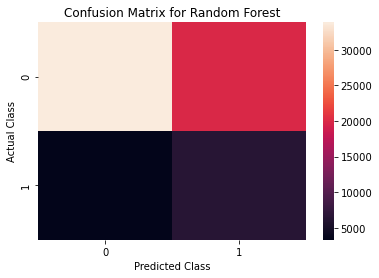

In [44]:
sns.heatmap(confusion_matrix(y_test, rf_y_pred))
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for Random Forest')
plt.show();